# Modelagem de T√≥picos com LDA, NMF e SVD
Neste notebook, vamos explorar a modelagem de t√≥picos utilizando tr√™s algoritmos diferentes: Latent Dirichlet Allocation (LDA), Non-negative Matrix Factorization (NMF), e Singular Value Decomposition (SVD). Nosso objetivo √© encontrar o melhor valor de \( k \) (n√∫mero de t√≥picos) para cada um desses algoritmos, utilizando m√©tricas espec√≠ficas a cada um. Por fim, vamos comparar os resultados de cada modelo.


In [11]:
# Libraries

import warnings

warnings.filterwarnings('ignore')
import re
import numpy as np
import gensim
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel, LsiModel, Nmf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from ulteis import preprocess

## Preparar dados 
Por essa parte ser repetitiva n√£o iremos detalhar muito, em resumo aplicamos preprocessamento j√° definido e uma vez que usaremos a biblioteca Gensim teremos que preparar os dados para se adequar ao padr√£o que a biblioteca aceita.

In [4]:
bbc_df = pd.read_csv("../data/bbc_data.csv")

text_df = bbc_df["data"].apply(preprocess)
labels_df = bbc_df["labels"]

# Lista com todas as palavras de todos os textos
texts_topics = [word.split() for word in text_df] 
# Criando um dicion√°rio, associa cada palavra a um id
id2word = corpora.Dictionary(texts_topics)
# Lista de tuplas (id, frequeÃÇncia) para todas as palavras.
corpus = [id2word.doc2bow(text) for text in texts_topics]

# Exemplo
print(corpus[222], "\n")
# Exemplo mapeado
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:222]])

[(4, 2), (39, 1), (40, 2), (67, 2), (70, 1), (85, 4), (90, 2), (95, 1), (106, 1), (112, 2), (119, 1), (133, 1), (138, 2), (142, 4), (143, 3), (148, 1), (153, 4), (161, 4), (168, 1), (175, 4), (178, 11), (185, 1), (194, 1), (233, 1), (244, 1), (246, 1), (250, 1), (258, 1), (272, 1), (276, 1), (281, 1), (282, 2), (289, 1), (296, 1), (299, 3), (304, 1), (319, 1), (327, 1), (334, 1), (343, 1), (348, 1), (352, 1), (363, 1), (371, 1), (377, 1), (384, 4), (386, 1), (387, 1), (388, 3), (398, 1), (399, 2), (400, 2), (401, 2), (402, 2), (408, 1), (424, 1), (426, 1), (427, 2), (430, 1), (431, 2), (436, 1), (437, 4), (441, 1), (478, 1), (483, 1), (509, 2), (512, 1), (514, 1), (524, 1), (600, 1), (623, 1), (632, 2), (634, 1), (674, 2), (723, 1), (736, 1), (749, 5), (776, 1), (830, 1), (848, 1), (859, 1), (893, 1), (894, 1), (909, 1), (922, 1), (923, 1), (928, 1), (934, 1), (957, 1), (959, 1), (993, 5), (994, 1), (995, 5), (996, 3), (1011, 1), (1013, 1), (1034, 1), (1040, 1), (1083, 1), (1099, 1), (

## Modelagem de T√≥picos com LDA

O **Latent Dirichlet Allocation (LDA)** √© um modelo probabil√≠stico que identifica t√≥picos em um conjunto de documentos, assumindo que cada documento √© composto por uma mistura de t√≥picos, e cada t√≥pico √© uma distribui√ß√£o de palavras.

### Coer√™ncia de T√≥picos
Mede a qualidade dos t√≥picos verificando se as palavras dentro de cada t√≥pico fazem sentido juntas. T√≥picos com alta coer√™ncia t√™m palavras semanticamente relacionadas, tornando os t√≥picos mais interpret√°veis.

### Perplexidade
Avalia o qu√£o bem o modelo se ajusta aos dados, com valores mais baixos indicando um melhor ajuste. No entanto, pode n√£o refletir diretamente a qualidade interpret√°vel dos t√≥picos, exigindo um equil√≠brio com a coer√™ncia.


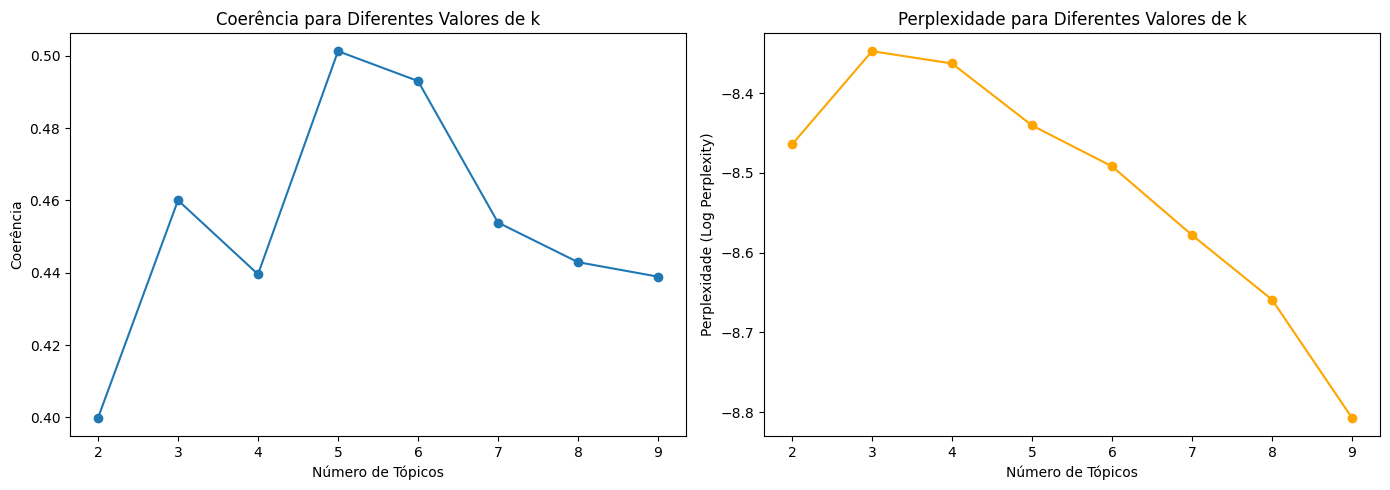

In [14]:
# FuncÃßaÃÉo para treinar o modelo e computar valores de correla√ß√£o e perplexi
def compute_coherence_values(dictionary, corpus, texts, list_range):
    coherence_values = []
    perplexity_values = []
    
    for num_topics in list_range:
        # Treinando o modelo LDA
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, 
                         update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        
        # Calculando a coer√™ncia
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        # Calculando a perplexidade
        perplexity_values.append(model.log_perplexity(corpus))
    
    return coherence_values, perplexity_values


# Plotagem 
list_range = [2,3,4,5,6,7,8,9]
coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts_topics, list_range=list_range)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot coherence values
ax1.plot(list_range, coherence_values, marker='o')
ax1.set_title('Coer√™ncia para Diferentes Valores de k')
ax1.set_xlabel('N√∫mero de T√≥picos')
ax1.set_ylabel('Coer√™ncia')

# Plot perplexity values
ax2.plot(list_range, perplexity_values, marker='o', color='orange')
ax2.set_title('Perplexidade para Diferentes Valores de k')
ax2.set_xlabel('N√∫mero de T√≥picos')
ax2.set_ylabel('Perplexidade (Log Perplexity)')

# Show the plots
plt.tight_layout()
plt.show()

### An√°lise dos Resultados do LDA
Com base no gr√°fico de coer√™ncia, podemos selecionar o valor de \( k \) = 5 que maximiza a coer√™ncia dos t√≥picos. Tamb√©m consideraremos a **perplexidade** para refinar a escolha de \( k \) = 5.


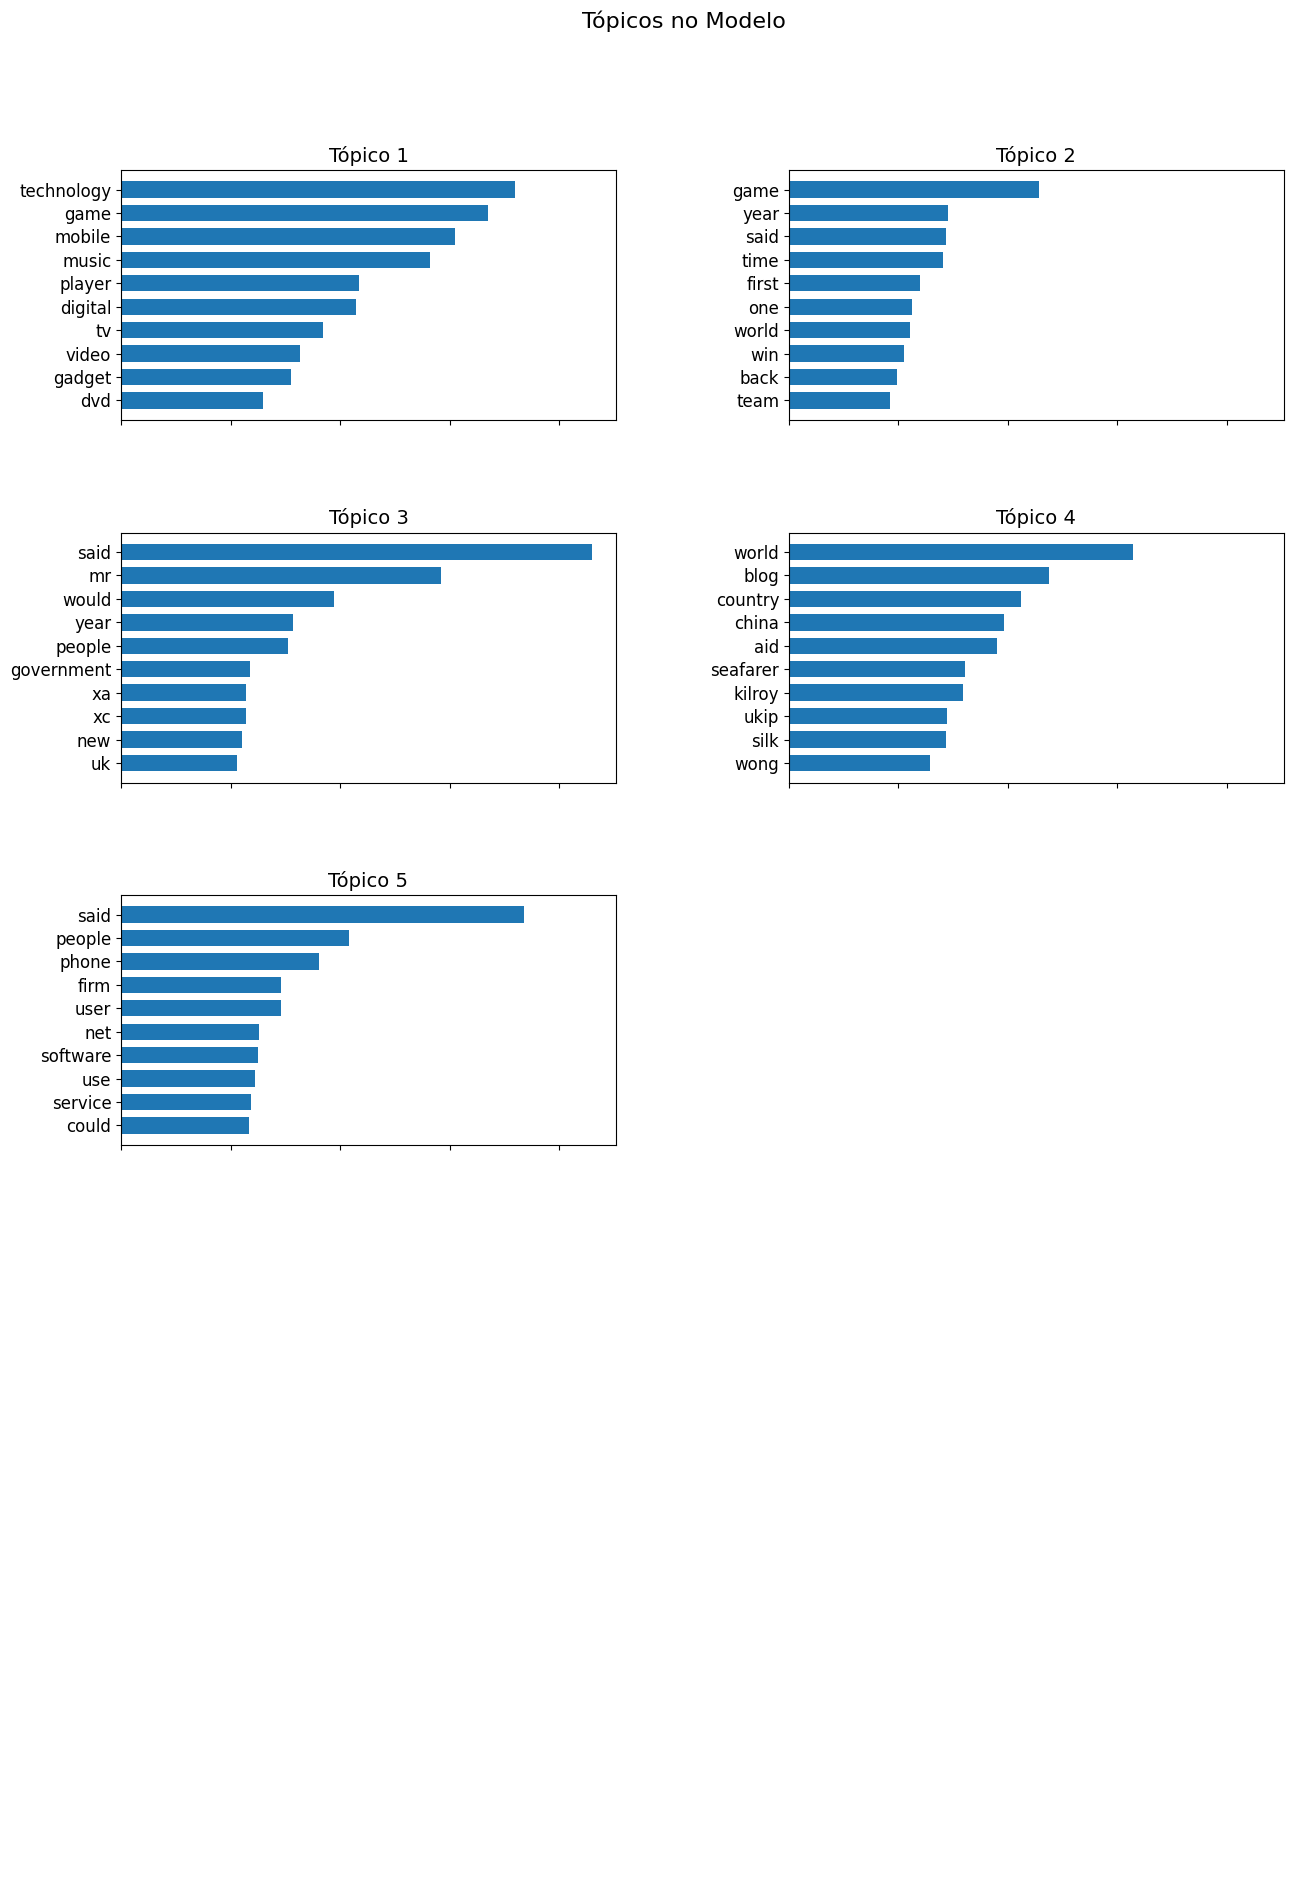

In [17]:
def plot_lda_topics(model, num_topics, num_words=10):
    fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            topic_words = model.show_topic(i, num_words)
            words, weights = zip(*topic_words)
            ax.barh(words, weights, height=0.7)
            ax.set_title(f'T√≥pico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)
        else:
            ax.axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'T√≥picos no Modelo', fontsize=16)
    plt.show()
    
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, 
                         update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
plot_lda_topics(lda, 5)

## Modelagem de T√≥picos com NMF

O **Non-negative Matrix Factorization (NMF)** √© um algoritmo de decomposi√ß√£o matricial que fatoriza a matriz de documentos em duas outras matrizes: uma que representa os t√≥picos e outra que representa a associa√ß√£o entre documentos e t√≥picos. Todos os valores gerados s√£o n√£o-negativos, o que facilita a interpreta√ß√£o dos t√≥picos.

Para validar o melhor n√∫mero de t√≥picos \( k \), vamos utilizar duas m√©tricas principais:

### 1. Sparsidade (Sparsity)
A **sparsidade** mede a quantidade de valores zero nas matrizes resultantes do NMF. Quanto maior a sparsidade, mais esparsa ser√° a matriz, o que significa que cada t√≥pico ser√° composto por poucas palavras e cada documento estar√° associado a poucos t√≥picos.

**Interpreta√ß√£o**: T√≥picos com alta sparsidade s√£o mais facilmente interpret√°veis, pois cada t√≥pico ser√° composto por um n√∫mero reduzido de palavras-chave. Isso facilita a compreens√£o do que o t√≥pico representa.

**Objetivo**: O valor ideal de \( k \) deve maximizar a sparsidade, mantendo os t√≥picos √∫teis e interpret√°veis.

### 2. Erro de Reconstru√ß√£o (Reconstruction Error)
O **erro de reconstru√ß√£o** mede a diferen√ßa entre a matriz original de documentos e a matriz reconstru√≠da a partir dos t√≥picos gerados pelo NMF.

**Interpreta√ß√£o**: Um erro de reconstru√ß√£o menor significa que a decomposi√ß√£o NMF est√° capturando bem as informa√ß√µes presentes na matriz original. No entanto, valores muito baixos de erro podem resultar em overfitting (muitos t√≥picos irrelevantes).

**Objetivo**: O valor de \( k \) ideal deve minimizar o erro de reconstru√ß√£o, garantindo que o modelo capture a estrutura dos dados sem gerar t√≥picos desnecess√°rios.

Ao balancear essas duas m√©tricas, podemos encontrar o n√∫mero \( k \) de t√≥picos que gera a melhor decomposi√ß√£o, com t√≥picos interpret√°veis e uma boa reconstru√ß√£o da matriz original.


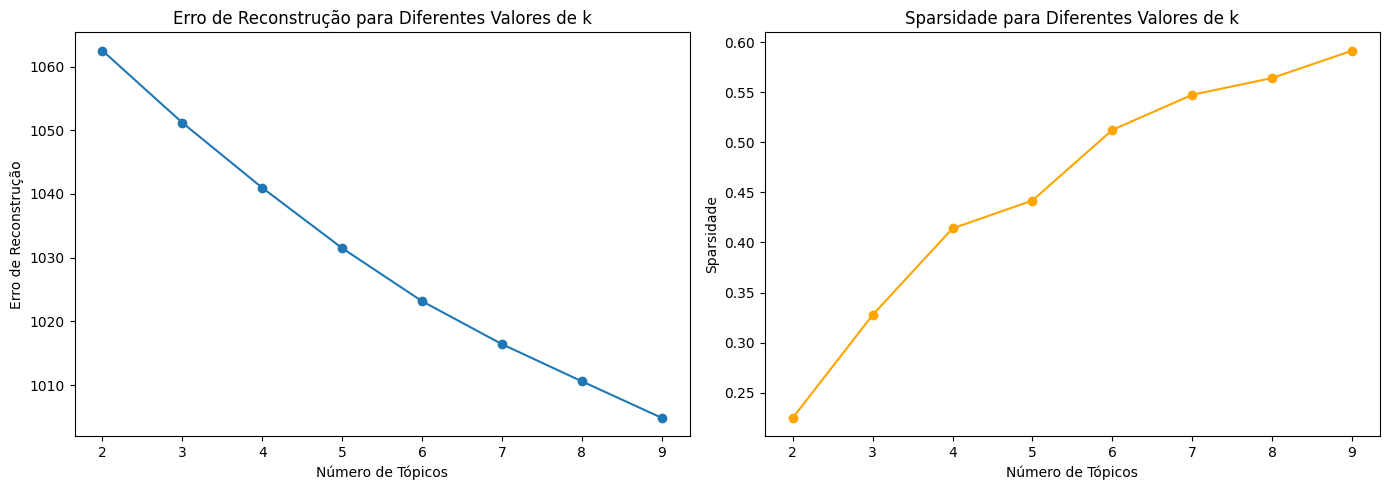

In [14]:
cv = CountVectorizer()
X = cv.fit_transform(text_df)

# Fun√ß√£o para calcular o erro de reconstru√ß√£o e a sparsidade
def compute_nmf_metrics(X, list_range):
    reconstruction_errors = []
    sparsity_values = []
    
    for num_topics in list_range:
        # Treinando o modelo NMF com Scikit-learn
        nmf = NMF(n_components=num_topics, random_state=100, init='nndsvd', max_iter=200)
        W = nmf.fit_transform(X)
        H = nmf.components_
        
        # Calculando o erro de reconstru√ß√£o
        reconstruction_error = np.linalg.norm(X - np.dot(W, H), 'fro')
        reconstruction_errors.append(reconstruction_error)
        
        # Calculando a sparsidade
        sparsity = (np.count_nonzero(W) + np.count_nonzero(H)) / (W.size + H.size)
        sparsity_values.append(1 - sparsity)  # Invertendo para valores maiores representarem maior sparsidade
    
    return reconstruction_errors, sparsity_values

# Lista de valores de k (n√∫mero de t√≥picos)
list_range = [2, 3, 4, 5, 6, 7, 8, 9]

# 2. Calcular os valores de erro de reconstru√ß√£o e sparsidade
reconstruction_errors, sparsity_values = compute_nmf_metrics(X, list_range)

# 3. Plotar os gr√°ficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotar Erro de Reconstru√ß√£o
ax1.plot(list_range, reconstruction_errors, marker='o')
ax1.set_title('Erro de Reconstru√ß√£o para Diferentes Valores de k')
ax1.set_xlabel('N√∫mero de T√≥picos')
ax1.set_ylabel('Erro de Reconstru√ß√£o')

# Plotar Sparsidade
ax2.plot(list_range, sparsity_values, marker='o', color='orange')
ax2.set_title('Sparsidade para Diferentes Valores de k')
ax2.set_xlabel('N√∫mero de T√≥picos')
ax2.set_ylabel('Sparsidade')

# Mostrar os gr√°ficos
plt.tight_layout()
plt.show()

### An√°lise dos Resultados do NMF
Com base nas observa√ß√µes dos gr√°ficos:ùëò = 5 ou ùëò = 6 pode ser um bom valor para o n√∫mero de t√≥picos. Isso ocorre porque, a partir desses valores, a redu√ß√£o no erro de reconstru√ß√£o come√ßa a se estabilizar, e a sparsidade aumenta a um n√≠vel que ainda permite uma boa interpretabilidade dos t√≥picos.


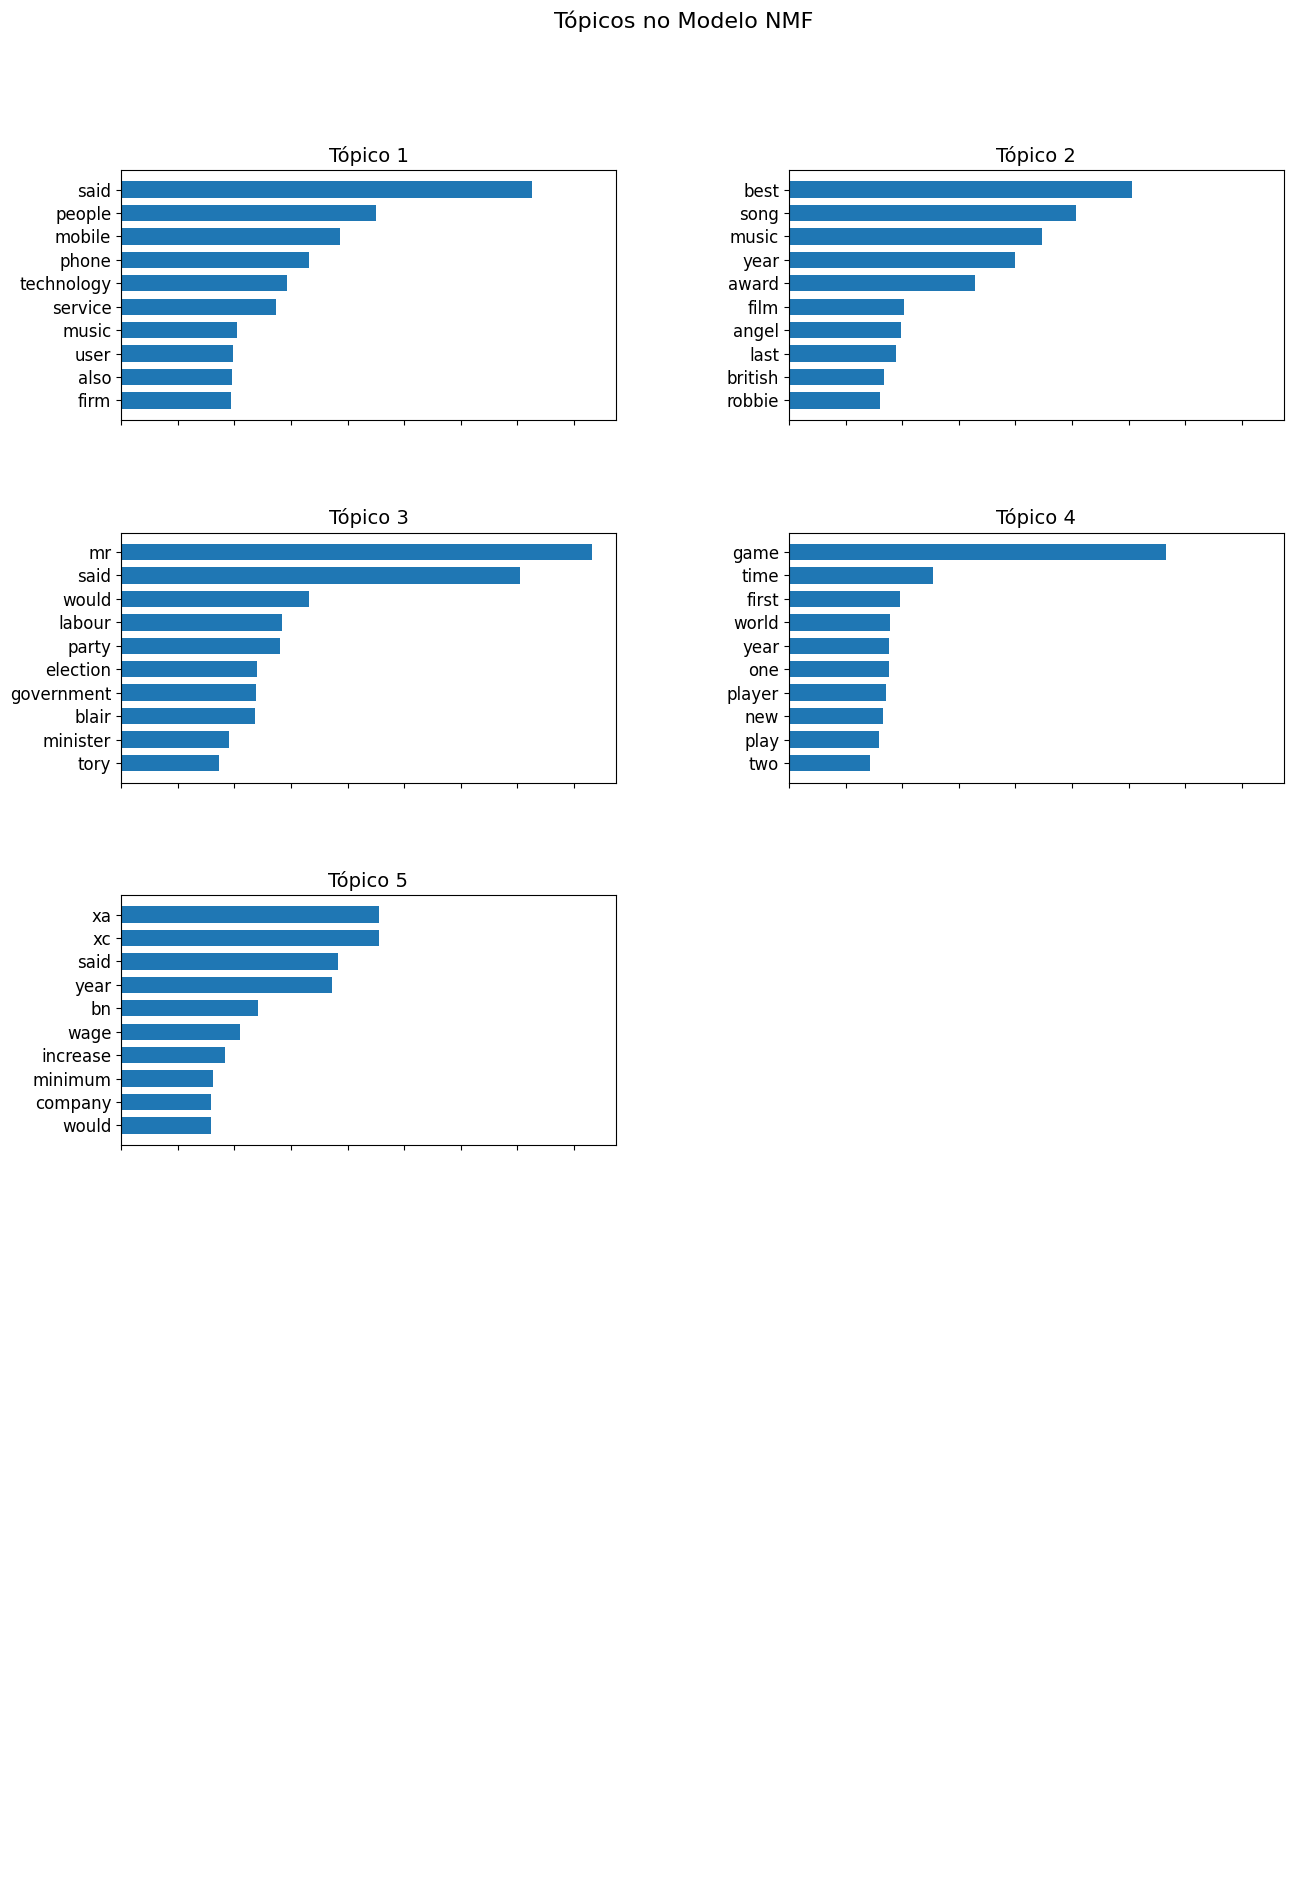

In [20]:
# Fun√ß√£o para exibir os t√≥picos
def plot_nmf_topics(model, feature_names, num_words=10):
    num_topics = model.components_.shape[0]
    fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            # Obtendo os √≠ndices das palavras mais importantes para cada t√≥pico
            top_words_idx = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [feature_names[idx] for idx in top_words_idx]
            top_weights = model.components_[i][top_words_idx]

            # Plotando os t√≥picos
            ax.barh(top_words, top_weights, height=0.7)
            ax.set_title(f'T√≥pico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)
        else:
            ax.axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'T√≥picos no Modelo NMF', fontsize=16)
    plt.show()

# Chamando a fun√ß√£o para plotar os t√≥picos
feature_names = cv.get_feature_names_out()  # Obtendo os nomes das palavras do CountVectorizer ou TfidfVectorizer
nmf = NMF(n_components=5, random_state=100, init='nndsvd', max_iter=200)
nmf.fit_transform(X)
plot_nmf_topics(nmf, feature_names, num_words=10)



## Modelagem de T√≥picos com SVD
O **Singular Value Decomposition (SVD)** √© uma t√©cnica de fatora√ß√£o matricial. Vamos utilizar a **vari√¢ncia explicada** e **valida√ß√£o cruzada** para definir o n√∫mero ideal de componentes \( k \).


### An√°lise dos Resultados do SVD
Aqui analisamos a **vari√¢ncia explicada** para identificar o n√∫mero ideal de componentes. Um valor de \(k\) que explica uma alta porcentagem da vari√¢ncia √© geralmente o melhor ponto de corte.


## Compara√ß√£o Final e Conclus√£o
Ap√≥s realizar a modelagem de t√≥picos com os algoritmos **LDA**, **NMF**, e **SVD**, observamos as diferen√ßas entre cada m√©todo:

- **LDA**: Gera t√≥picos probabil√≠sticos com uma interpreta√ß√£o sem√¢ntica clara. O n√∫mero de t√≥picos \(k\) foi otimizado com base na coer√™ncia de t√≥picos.
- **NMF**: Utilizou o erro de reconstru√ß√£o como m√©trica principal. O NMF √© eficaz para gerar t√≥picos esparsos e interpret√°veis.
- **SVD**: Baseado na vari√¢ncia explicada, o SVD √© √∫til para redu√ß√£o de dimensionalidade, mas pode n√£o ser t√£o interpret√°vel quanto LDA ou NMF.

Cada m√©todo tem suas vantagens e desvantagens. O LDA √© mais adequado quando a sem√¢ntica dos t√≥picos √© importante, enquanto o NMF pode ser mais eficaz quando a interpreta√ß√£o esparsa √© desejada. O SVD √© uma ferramenta poderosa para an√°lise quantitativa.
